# 機械学習ハンズオン　練習問題2：レンタル自転車の需要予測

[UCIのbike sharingデータセット](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)を使って、気象データなどからその日の自転車の貸出台数を予測します。


【課題】

 1. 貸出台数と相関がなさそうなデータはあるでしょうか？もしあれば、それらは学習させる特徴量から除外してください。
 1. データどうしで相関が高いものはあるでしょうか？もしあれば、それらは一つの特徴量にまとめてください。

【ヒント】

 * データどうしの相関を見るには、pandas.DataFrame.corr()とseaborn.heatmap()の併用が便利です。→[参考](https://note.nkmk.me/python-pandas-corr/)
 * [seaborn.pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html)も役に立ちます。
 * グラフのサイズを変えたいときは、[ここ](https://qiita.com/cnloni/items/20b5908fbae755192498#1-8-%E5%9B%B3%E3%81%AE%E3%82%B5%E3%82%A4%E3%82%BA%E3%82%92%E6%8C%87%E5%AE%9A%E3%81%97%E3%81%9F%E3%81%84)を参考にしてみてください。

【注意点】

`cnt`列は、`casual`列と`registered`列の合計です。したがって、`cnt`を予測する場合には、`casual`と`registered`は学習させる特徴量から外さなければなりません。

## 前準備

In [0]:
# ここで必要なimportを行ってください。
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### データセットファイルの取得（zipの展開）

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!unzip -o Bike-Sharing-Dataset.zip

--2019-07-22 15:07:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.06MB/s    in 0.3s    

2019-07-22 15:07:37 (1.06 MB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


### データセットの読込み

In [0]:
df = pd.read_csv('day.csv', sep=',', index_col=0)

In [4]:
df

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822


## データの分析

### 特徴の相関関係

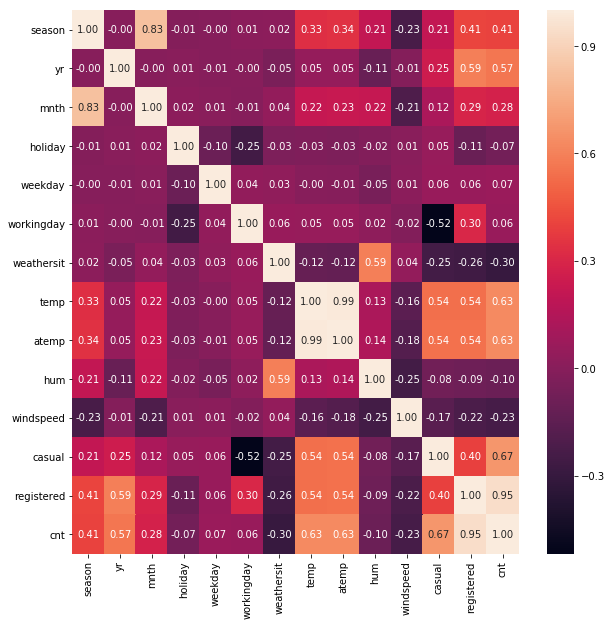

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

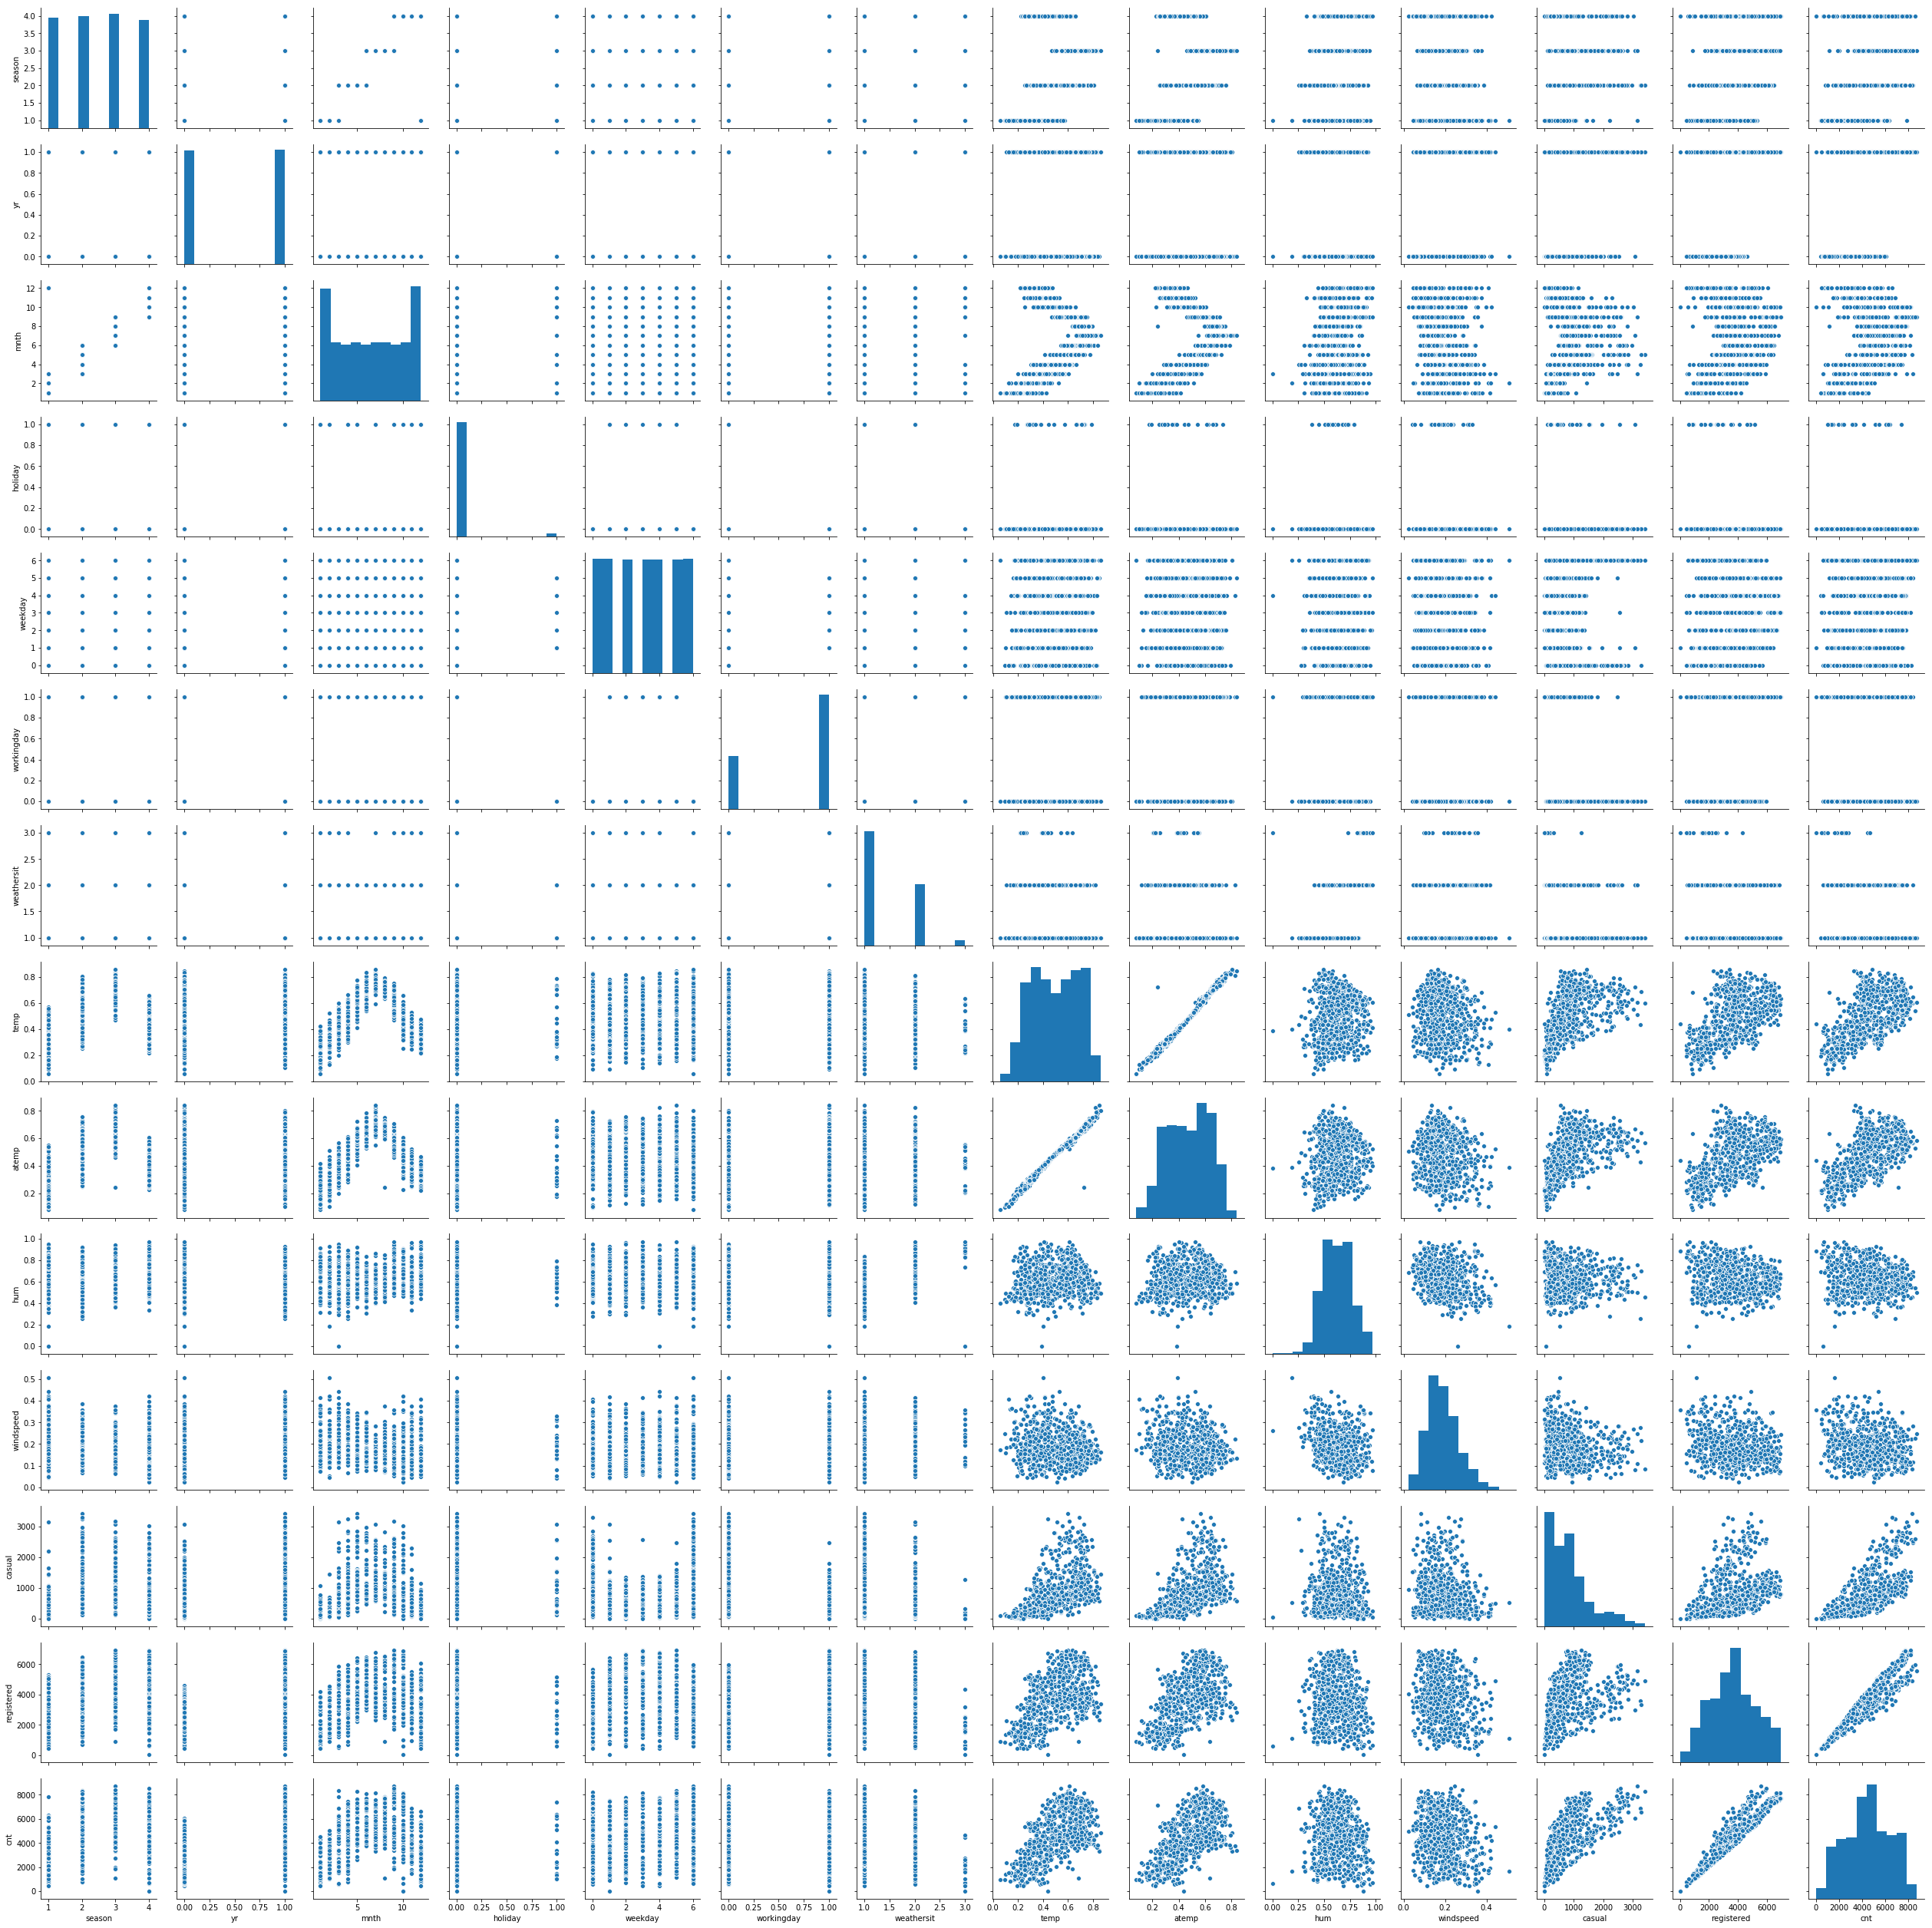

In [6]:
sns.pairplot(df)

## 学習データの作成

### ダミー化

In [7]:
df = pd.get_dummies(df, columns=['mnth', 'weathersit'])
df.head()

,dteday,season,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,0,6,0,0.344167,0.363625,0.805833,0.160446,331,654,985,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2011-01-02,1,0,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2011-01-03,1,0,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2011-01-04,1,0,0,2,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,2011-01-05,1,0,0,3,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### ラベル

In [8]:
ys = df['cnt'].values
ys.shape

(731,)

### 不要な特徴の除去

In [9]:
df = df.drop(['dteday', 'season', 'holiday', 'weekday', 'temp', 'hum', 'casual', 'registered', 'cnt'], axis=1)
df.head()

,yr,workingday,atemp,windspeed,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,
1,0,0,0.363625,0.160446,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0.353739,0.248539,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0.189405,0.248309,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0.212122,0.160296,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,1,0.229270,0.186900,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 特徴量

In [10]:
xs = df.values
xs.shape

(731, 19)

### 訓練データとテストデータの分割

In [11]:
train_xs, test_xs, train_ys, test_ys = train_test_split(xs, ys, test_size=0.2)
print(train_xs.shape, test_xs.shape, train_ys.shape, test_ys.shape)

(584, 19) (147, 19) (584,) (147,)


## モデルの構築とコンパイル

In [12]:
opt = tf.keras.optimizers.SGD(0.01)
reg = tf.keras.regularizers.l2(0.003)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=xs.shape[1], kernel_regularizer=reg)
])
model.compile(optimizer=opt, loss='mean_squared_error')

W0722 15:08:23.807191 140347253729152 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


## 学習実行
データの80%を学習に、20%を検証に使用

In [14]:
num_epochs = 1000
hist = model.fit(x=train_xs, y=train_ys, validation_split=0.2, epochs=num_epochs)

Train on 467 samples, validate on 117 samples
Epoch 1/1000
467/467 [==============================] - 1s 2ms/sample - loss: 13796356.4561 - val_loss: 6676027.5726
Epoch 2/1000
467/467 [==============================] - 0s 100us/sample - loss: 4683752.9133 - val_loss: 3019995.1838
Epoch 3/1000
467/467 [==============================] - 0s 95us/sample - loss: 2826710.4197 - val_loss: 2193231.2543
Epoch 4/1000
467/467 [==============================] - 0s 159us/sample - loss: 2368085.7353 - val_loss: 1938965.9541
Epoch 5/1000
467/467 [==============================] - 0s 101us/sample - loss: 2186875.8233 - val_loss: 1801844.5000
Epoch 6/1000
467/467 [==============================] - 0s 103us/sample - loss: 2067685.7805 - val_loss: 1706687.2585
Epoch 7/1000
467/467 [==============================] - 0s 110us/sample - loss: 1963230.7227 - val_loss: 1629259.9444
Epoch 8/1000
467/467 [==============================] - 0s 108us/sample - loss: 1873406.4010 - val_loss: 1557722.0780
Epoch 9/1000

## 評価

Text(0, 0.5, 'loss')

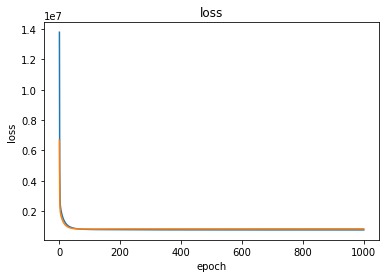

In [15]:
%matplotlib inline
plt.plot(range(1, num_epochs+1), hist.history["loss"])
plt.plot(range(1, num_epochs+1), hist.history["val_loss"])
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")

## テストデータの予測

In [16]:
model.predict(test_xs)

array([[4696.2246 ],
       [7068.125  ],
       [5061.0693 ],
       [6761.625  ],
       [2721.5024 ],
       [6657.5264 ],
       [3769.6619 ],
       [1098.3466 ],
       [6469.667  ],
       [5947.838  ],
       [5131.54   ],
       [4760.123  ],
       [5036.0967 ],
       [6116.4697 ],
       [5339.6543 ],
       [6881.793  ],
       [4782.832  ],
       [5739.6396 ],
       [5900.217  ],
       [3399.9846 ],
       [2299.5137 ],
       [3866.3894 ],
       [5387.8613 ],
       [5125.7803 ],
       [5417.851  ],
       [6976.8154 ],
       [1947.5281 ],
       [6718.1504 ],
       [3651.1777 ],
       [6857.1963 ],
       [6978.617  ],
       [6790.45   ],
       [4950.4062 ],
       [5774.6885 ],
       [4062.6897 ],
       [6181.1553 ],
       [4370.947  ],
       [6431.8438 ],
       [6878.464  ],
       [2590.8914 ],
       [2278.255  ],
       [4219.883  ],
       [6605.4766 ],
       [3941.5664 ],
       [4422.663  ],
       [4911.5625 ],
       [6680.6553 ],
       [5019.